In [1]:
import pickle

In [2]:
with open("../../datasets/mnist.pickle","rb") as f:
    mnist = pickle.load(f)

In [3]:
type(mnist)

dict

In [4]:
import sys, os

In [5]:
# 查看文件的大小
os.path.getsize("../../datasets/mnist.pickle")

54950621

In [6]:
# 查看变量的大小
sys.getsizeof(mnist)

368

In [7]:
print(mnist.keys())

dict_keys(['data', 'train_size', 'x_train_shape', 'y_train_shape', 'test_size', 'x_test_shape', 'y_test_shape', 'num_classes', 'img_shape', 'img_size_flat'])


In [8]:
(x_train,y_train),(x_test,y_test) = mnist["data"]

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
y_train.shape

(60000,)

In [11]:
x_train = x_train / 255.
x_test = x_test / 255.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import tensorflow as tf

In [14]:
y_train_cls = y_train
y_train = tf.keras.utils.to_categorical(y_train_cls)

y_test_cls = y_test
y_test = tf.keras.utils.to_categorical(y_test_cls)

In [15]:
y_train_cls.shape

(60000,)

In [16]:
y_test_cls.shape

(10000,)

## global vars

In [17]:
train_size = mnist["train_size"]
test_size = mnist["test_size"]
img_shape = mnist["img_shape"]
num_classes = mnist["num_classes"]
num_channels = 1

filter_size1 = 5
num_filter1 = 16

filter_size2 = 5
num_filter2 = 36

fc_size = 128
img_size = 28

## helper function for plotting images 

In [18]:
def plot_images(images,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3,figsize=(10,10))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap="binary")
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "Ture: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## plot a few images to see if data is correct

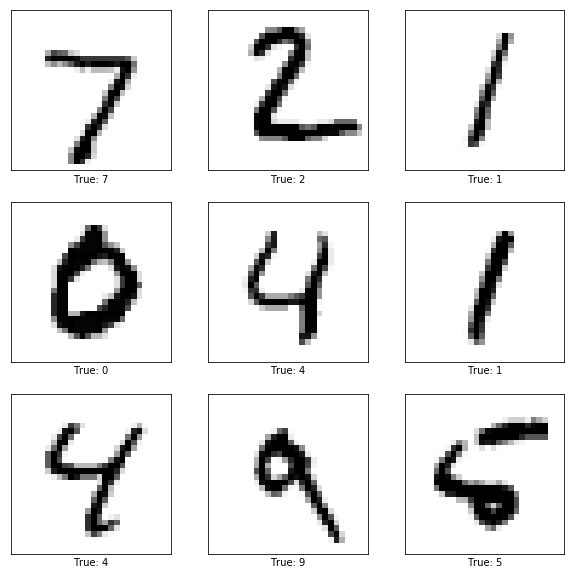

In [19]:
images = x_test[0:9]
cls_true = y_test_cls[0:9]

plot_images(images,cls_true)

In [20]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))

In [21]:
def new_biases(shape):
    """
    shape is a tuple.
    """
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))

In [22]:
b = new_biases((10,))

Instructions for updating:
Colocations handled automatically by placer.


## conv layer

In [23]:
def new_conv_layer(_input,\
                  num_input_channels,\
                  filter_size,\
                  num_filters,\
                  use_pooling=True):
    shape = (filter_size,filter_size,num_input_channels,num_filters)
    weights = new_weights(shape)
    biases = new_biases((num_filters,))
    
    layer = tf.nn.conv2d(input=_input,filter=weights,strides=[1,1,1,1],padding="SAME")
    
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
    layer = tf.nn.relu(layer)

    return layer, weights
    
    

In [24]:
x_test.shape

(10000, 28, 28)

In [25]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer,(-1,num_features))
    return layer_flat, num_features

In [26]:
def new_fc_layer(_input,\
                num_inputs,\
                num_outputs,\
                use_relu=True):
    weights = new_weights(shape=(num_inputs,num_outputs))
    biases = new_biases(shape=(num_outputs,))
    
    layer = tf.matmul(_input,weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [27]:
x = tf.placeholder(tf.float32,shape=[None,img_shape[0],img_shape[1]],name="x")
x_images = tf.reshape(x,[-1,img_size,img_size,num_channels])

y_true = tf.placeholder(tf.float32,shape=[None,num_classes])

y_true_cls = tf.argmax(y_true,axis=1)


In [28]:
layer_conv1, weights_conv1 = new_conv_layer(_input=x_images,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filter1,
                                            use_pooling=True)

In [29]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [30]:
layer_conv2, weights_conv2 = new_conv_layer(_input=layer_conv1,
                                            num_input_channels=num_filter1,
                                            filter_size=filter_size2,
                                            num_filters=num_filter2,
                                            use_pooling=True)

In [31]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [32]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [33]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [34]:
num_features

1764

In [35]:
layer_fc1 = new_fc_layer(_input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [36]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [37]:
layer_fc2 = new_fc_layer(_input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [38]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [39]:
y_pred = tf.nn.softmax(layer_fc2)

In [40]:
y_pred_cls = tf.argmax(y_pred,axis=1)

In [42]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,labels=y_true)

In [43]:
cost = tf.reduce_mean(cross_entropy)

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [45]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [46]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [47]:
session = tf.Session()

In [48]:
session.run(tf.global_variables_initializer())

In [49]:
train_batch_size = 16

In [50]:
total_iteration = 0

In [51]:
import time

In [65]:
def next_batch(batch_size):
    idx = np.random.randint(low=0,high=train_size,size=batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    y_batch_cls = y_train_cls[idx]

    return x_batch, y_batch, y_batch_cls

In [76]:
from datetime import timedelta

In [78]:
def optimize(num_iterations):
    global total_iteration
    
    start_time = time.time()
    
    for i in range(total_iteration,total_iteration+num_iterations):
        x_batch,y_true_batch,_ = next_batch(batch_size=train_batch_size)
        
        feed_dict_train = {x:x_batch,y_true:y_true_batch}
        
        session.run(optimizer,feed_dict=feed_dict_train)
        
        if i % 100 ==0 :
            acc = session.run(accuracy,feed_dict=feed_dict_train)
            
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1,acc))
            
    total_iteration += num_iterations
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [ ]:
feed_dict_test = {x:x_test,y_true:y_test,y_true_cls:y_test_cls}

In [ ]:
def print_accuracy():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test set:{0:.1%}".format(acc))

In [54]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)

    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [87]:
from sklearn.metrics import confusion_matrix

In [95]:
def plot_confusion_matrix(cls_pred):
    cls_true = y_test_cls
#     cls_pred = session.run(y_pred_cls,feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    print(cm)
    
#     plt.imshow(cm,interpolation="nearest",cmap=plt.cm.Blues)
    plt.matshow(cm)
    
#     plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
    plt.show()

In [ ]:
np.set_printoptions(precision=1)

In [56]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False):
    cls_pred = np.zeros(shape=test_size,dtype=np.int)
    
    i = 0
    while i < test_size:
        j = min (i + test_batch_size, test_size)
        
        images = x_test[i:j,:]
        labels = y_test[i:j,:]
        
        feed_dict = {x:images,
                    y_true:labels}
        
        cls_pred[i:j] = session.run(y_pred_cls,feed_dict=feed_dict)
        
        i = j
        
    cls_true = y_test_cls
    
    correct = (cls_true == cls_pred)
    
    correct_sum = correct.sum()
    
    acc = float(correct_sum)/test_size
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, test_size))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
        
    
    
    

In [57]:
print_test_accuracy()

Accuracy on Test-Set: 9.0% (900 / 10000)


Time usage: 0:00:00
Accuracy on Test-Set: 11.9% (1191 / 10000)
Example errors:


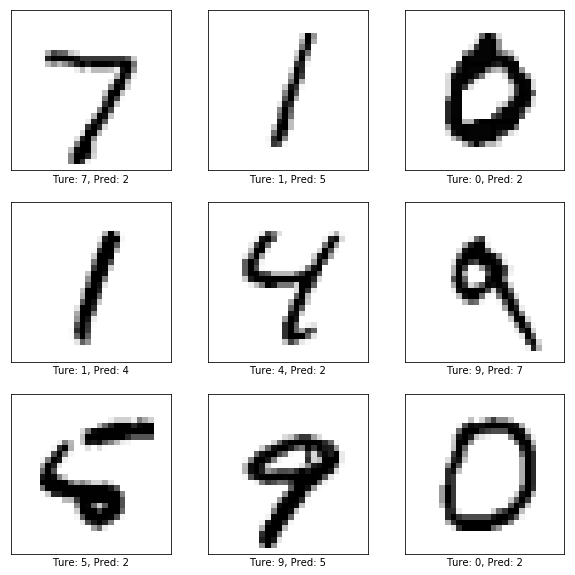

Confusion Matrix:
[[211   0 320   0 328   8   1   1   4 107]
 [  0   1 152   0 793 125   0   2   6  56]
 [ 78  19 550   0 274  10   0   0   0 101]
 [140   0 472   0 316  57   0   8   0  17]
 [108   7 394   0 372  33   3  10   3  52]
 [214   3 407   0 178  30   2  17  12  29]
 [ 20   1 745   0 123   2   0   0   0  67]
 [ 19   0 570   0 249 116  28   7   4  35]
 [ 98   1 282   0 539  43   1   3   2   5]
 [ 28   0 307   0 566  38  13  32   7  18]]


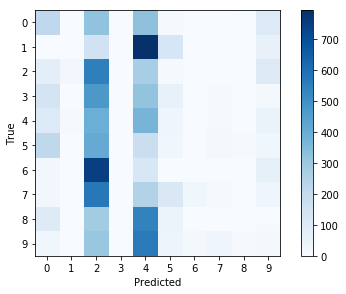

In [88]:
optimize(1)
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

Optimization Iteration:    201, Training Accuracy:  68.8%
Optimization Iteration:    301, Training Accuracy:  68.8%
Optimization Iteration:    401, Training Accuracy:  68.8%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy: 100.0%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  93.8%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy: 100.0%
Time usage: 0:00:16
Accuracy on Test-Set: 92.0% (9201 / 10000)
Example errors:


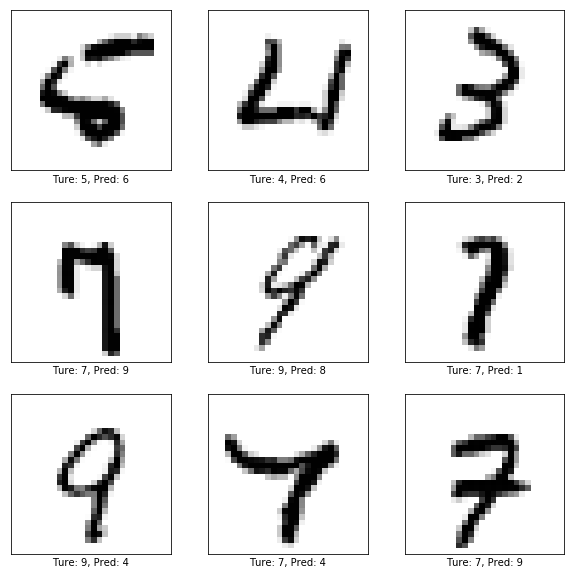

In [90]:
optimize(num_iterations=999)
print_test_accuracy(show_example_errors=True)

Accuracy on Test-Set: 92.0% (9201 / 10000)
Confusion Matrix:
[[ 950    0    1    1    1    4   15    1    7    0]
 [   0 1115    3    1    0    2    4    0   10    0]
 [   7    1  952    8   14    1   19    5   23    2]
 [   3    2   22  907    1   24    3    4   38    6]
 [   1    2    3    0  940    0   16    1    6   13]
 [   4    5    3   16   10  812   18    1   20    3]
 [   6    6    2    0    8   10  925    0    1    0]
 [   3   21   31    2   19    1    1  852   18   80]
 [   4    4    7   16   11   11    9    3  895   14]
 [   9    6    7    9   96    8    1    4   16  853]]


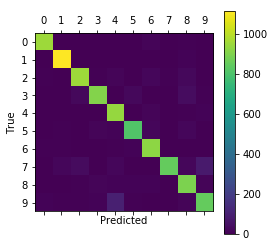

In [96]:
print_test_accuracy(show_confusion_matrix=True)